# Install Libraries if Needed (Only Run Once)

In [1]:
# !pip install tensorflow==2.11.*

# Import Libraries

In [2]:
# Interactive Plotting

# for jupyter notebooks
%matplotlib notebook 

# for jupyter labs
# %matplotlib widget 

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.integrate import odeint
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



# Burgers Equation

$$
u_t + u u_x = \frac{0.01}{\pi} u_{xx}, \quad x \in (-1, 1), t \in (0, 0.99],\\
u(x,0) = -\sin(\pi x), \\
u(-1,t) = u(1,t) = 0
$$

# Define Generate Test Data Function

In [6]:
def gen_testdata():
    data = np.load("dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    Nx = len(x)
    Nt = len(t)
    return X, y, Nx, Nt

# Define PDE

In [7]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

# Define Geometry

In [9]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Define ICs/BCs

In [10]:
bc = dde.DirichletBC(geomtime, # geometry
                     lambda x: 0, # value of specified boundary
                     lambda _, on_boundary: on_boundary # check if point is on specified boundary (function of coordinates and boolean on_boundary returns boolean)
                    )
ic = dde.IC(geomtime, # geometry
            lambda x: -np.sin(np.pi * x[:, 0:1]), # value of initial condition
            lambda _, on_initial: on_initial # check if point is an initial condition (function of coordinates and boolean on_initial returns boolean)
           )

# Construct Data (geometry + PDE + ICs/BCs)

In [12]:
data = dde.data.TimePDE(geomtime, # geometry
                        pde, # pde
                        [bc, ic], # ICs/BCs
                        num_domain=2540, # number of points in domain
                        num_boundary=80, # number of points on boundary
                        num_initial=160 # number of points on initial 
                       )

# Define Network Architecture

In [13]:
net = dde.maps.FNN([2] + [20] * 3 + [1], # layers
                   "tanh", # activation function
                   "Glorot normal" # initializer
                  )

# Define Model (data + net)

In [14]:
model = dde.Model(data, net)

# Train the Model
Here we train the model twice.  Once with Adam optimizer for initial training.  Then again with L-BFGS-B optimizer for finetuning.

In [15]:
model.compile("adam", lr=1e-3)
model.train(epochs=15000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.137511 s



C:\Users\gasan\anaconda3\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.960206 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.25e-01, 3.76e-02, 5.38e-01]    [1.25e-01, 3.76e-02, 5.38e-01]    []  
1000      [4.29e-02, 1.03e-03, 5.86e-02]    [4.29e-02, 1.03e-03, 5.86e-02]    []  
2000      [3.27e-02, 1.04e-04, 4.66e-02]    [3.27e-02, 1.04e-04, 4.66e-02]    []  
3000      [2.47e-02, 4.82e-05, 3.74e-02]    [2.47e-02, 4.82e-05, 3.74e-02]    []  
4000      [1.01e-02, 4.69e-05, 7.86e-03]    [1.01e-02, 4.69e-05, 7.86e-03]    []  
5000      [5.31e-03, 2.87e-05, 3.51e-03]    [5.31e-03, 2.87e-05, 3.51e-03]    []  
6000      [3.09e-03, 1.88e-05, 1.91e-03]    [3.09e-03, 1.88e-05, 1.91e-03]    []  
7000      [3.04e-03, 2.16e-05, 1.33e-03]    [3.04e-03, 2.16e-05, 1.33e-03]    []  
8000      [1.91e-03, 1.21e-05, 9.93e-04]    [1.91e-03, 1.21e-05, 9.93e-04]    []  
9000      [1.58e-03, 8.28e-06, 7.92e-04]    [1.58e-03, 8.28e-06, 7.92e-04]    []  
10000   

Saving loss history to C:\Users\gasan\Desktop\book\gitt\Advection-Linear-Diffusion\HAL-Physics-Informed-AI-Tutorial\loss_Burgers.dat ...
Saving training data to C:\Users\gasan\Desktop\book\gitt\Advection-Linear-Diffusion\HAL-Physics-Informed-AI-Tutorial\train_Burgers.dat ...
Saving test data to C:\Users\gasan\Desktop\book\gitt\Advection-Linear-Diffusion\HAL-Physics-Informed-AI-Tutorial\test_Burgers.dat ...


<IPython.core.display.Javascript object>


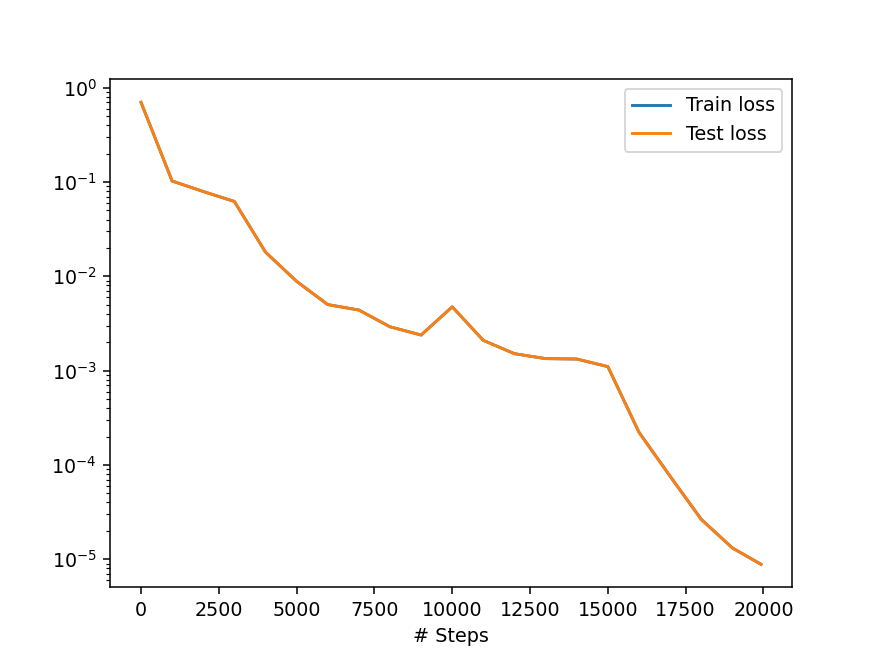

<IPython.core.display.Javascript object>


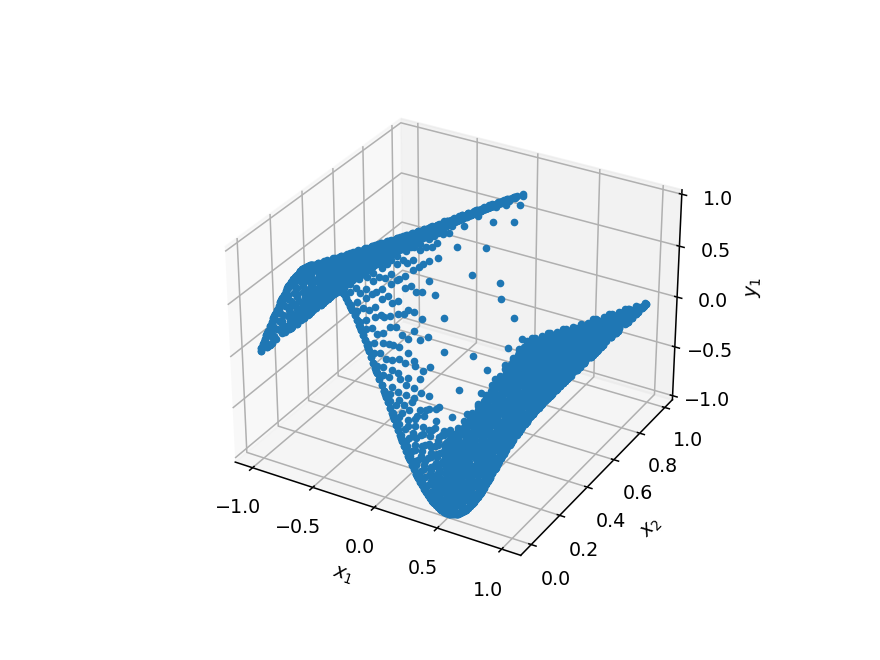

In [16]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname='loss_Burgers.dat', train_fname='train_Burgers.dat',test_fname='test_Burgers.dat')


# Load the Test Data

In [17]:
x_test, y_true, Nx, Nt = gen_testdata()
y_pred = model.predict(x_test)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test_burgers.dat", np.hstack((x_test, y_true, y_pred)))

L2 relative error: 0.0027972023561574507


In [18]:
X_test, T_test = x_test[:,0], x_test[:,1]
X = X_test.reshape((Nt, Nx))
T = T_test.reshape((Nt, Nx))
Y_pred = y_pred.reshape((Nt, Nx))
Y_test = y_true.reshape((Nt, Nx))

<IPython.core.display.Javascript object>


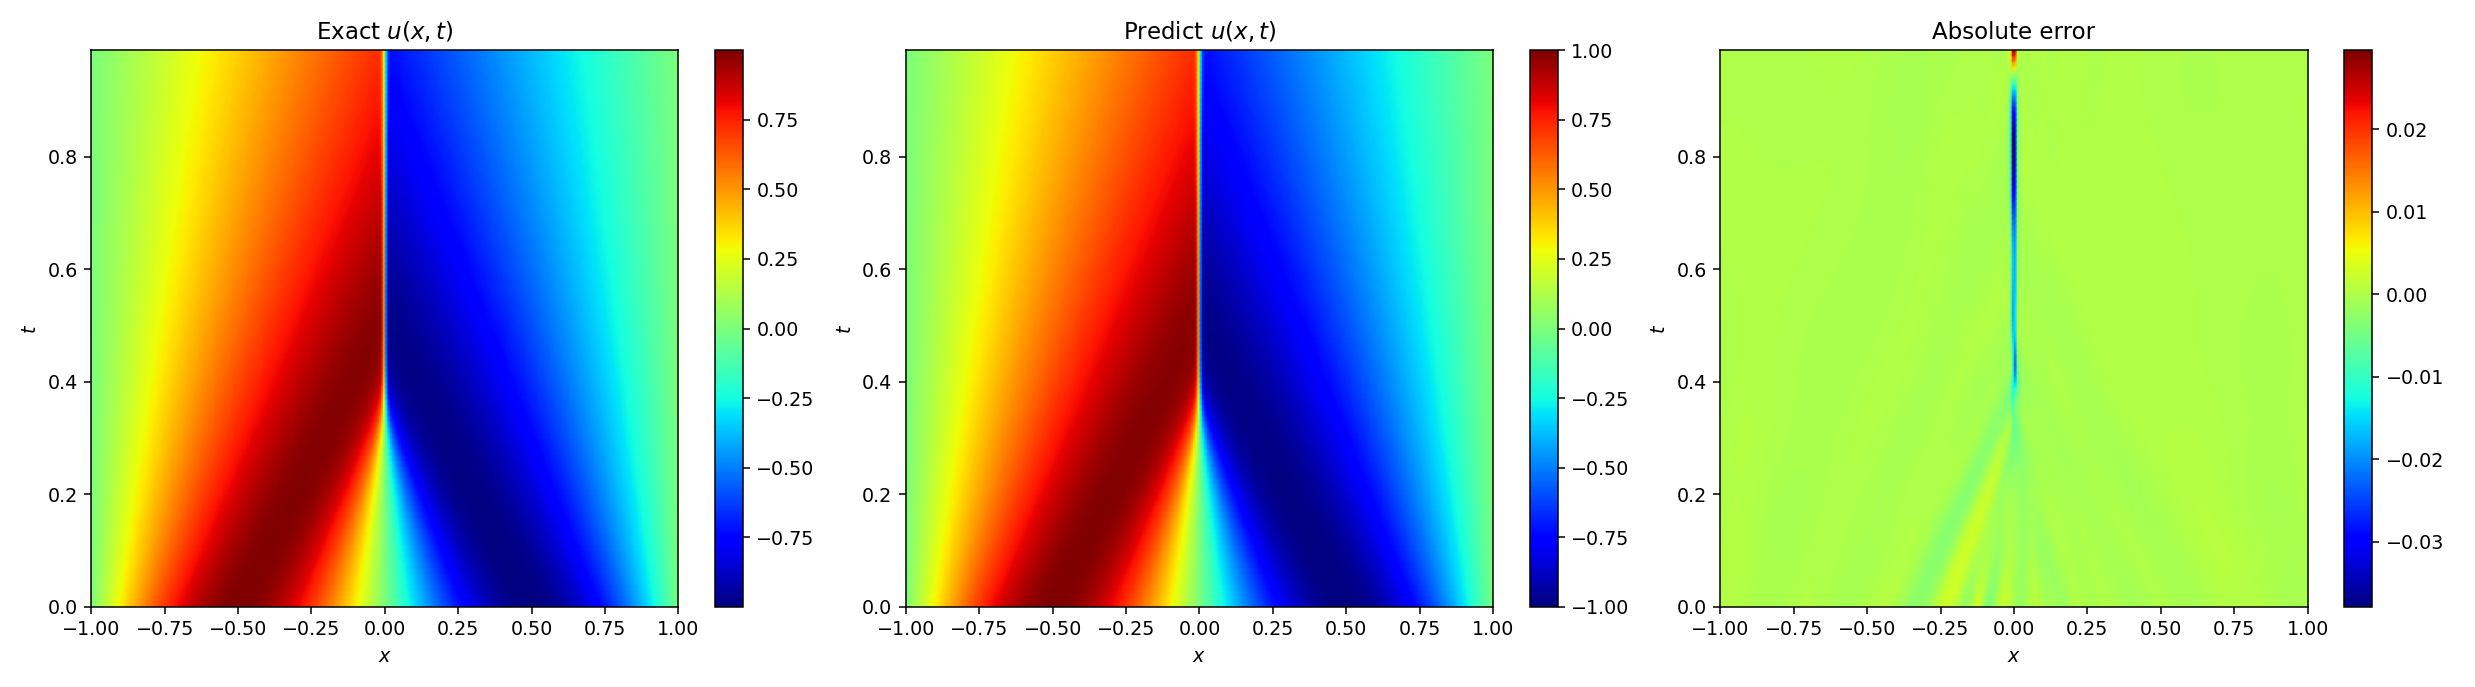

In [19]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, Y_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, Y_pred - Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


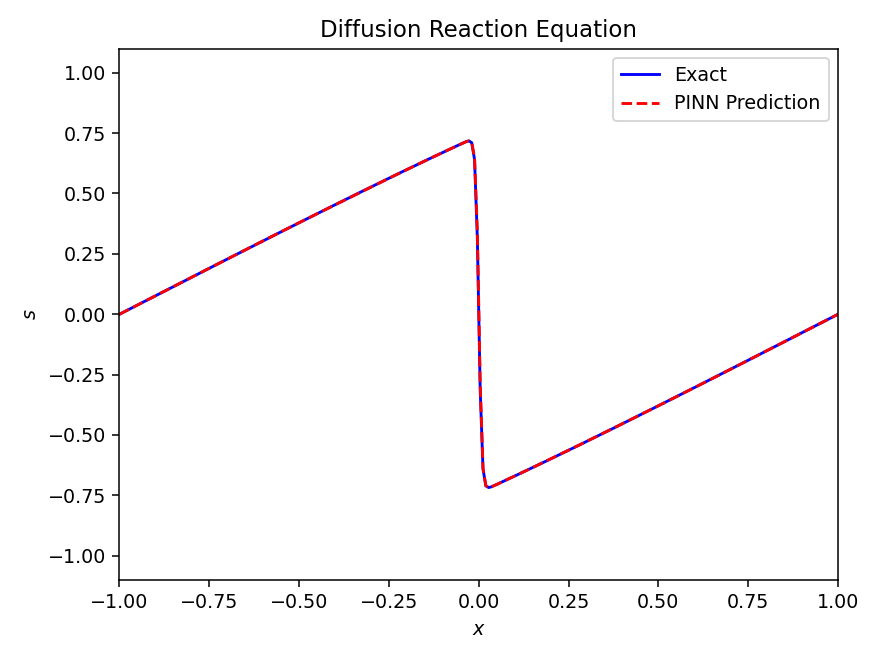

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(X[0], Y_test[0], 'b-', label='Exact')
ax.plot(X[0], Y_pred[0], 'r--', label='PINN Prediction')
ylim = plt.ylim()
xlim = [-1, 1]
plt.tight_layout()


for i in range(Nt):
    ax.clear()
    ax.plot(X[i], Y_test[i], 'b-', label='Exact')
    ax.plot(X[i], Y_pred[i], 'r--', label='PINN Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$s$')
    plt.title(f'Diffusion Reaction Equation')
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.canvas.draw()

# Optionally Refine by Adding Additional Points Near Potential Shock (True Shock Occurs at Low to Zero Viscosity)

In [24]:
X_reample = geomtime.random_points(100000)
err = 1
while err > 0.005:
    f = model.predict(X_reample, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new point:", X_reample[x_id], "\n")
    data.add_anchors(X_reample[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(
        epochs=10000, disregard_previous_best=True, callbacks=[early_stopping]
    )
    model.compile("L-BFGS-B")
    losshistory, train_state = model.train()

Mean residual: 3.979e-03
Adding new point: [0.00141644 0.9853269 ] 

Compiling model...
'compile' took 0.616925 s

Training model...

Step      Train loss                        Test loss                         Test metric
19921     [1.94e-03, 1.76e-08, 1.08e-06]    [7.73e-06, 1.76e-08, 1.08e-06]    []  
20000     [3.20e-04, 4.45e-07, 2.12e-05]    [2.55e-04, 4.45e-07, 2.12e-05]    []  
21000     [4.09e-05, 2.68e-08, 9.12e-06]    [4.01e-05, 2.68e-08, 9.12e-06]    []  
22000     [2.99e-05, 1.30e-08, 8.33e-06]    [2.95e-05, 1.30e-08, 8.33e-06]    []  
23000     [2.63e-05, 1.48e-08, 7.84e-06]    [2.61e-05, 1.48e-08, 7.84e-06]    []  
Epoch 23000: early stopping

Best model at step 23000:
  train loss: 3.42e-05
  test loss: 3.39e-05
  test metric: []

'train' took 23.987869 s

Compiling model...
'compile' took 0.517840 s

Training model...

Step      Train loss                        Test loss                         Test metric
23000     [2.63e-05, 1.48e-08, 7.84e-06]    [2.61e-05, 1.48e-

Saving loss history to C:\Users\gasan\Desktop\book\gitt\Advection-Linear-Diffusion\HAL-Physics-Informed-AI-Tutorial\loss_Burgers_RAR.dat ...
Saving training data to C:\Users\gasan\Desktop\book\gitt\Advection-Linear-Diffusion\HAL-Physics-Informed-AI-Tutorial\train_Burgers_RAR.dat ...
Saving test data to C:\Users\gasan\Desktop\book\gitt\Advection-Linear-Diffusion\HAL-Physics-Informed-AI-Tutorial\test_Burgers_RAR.dat ...


<IPython.core.display.Javascript object>


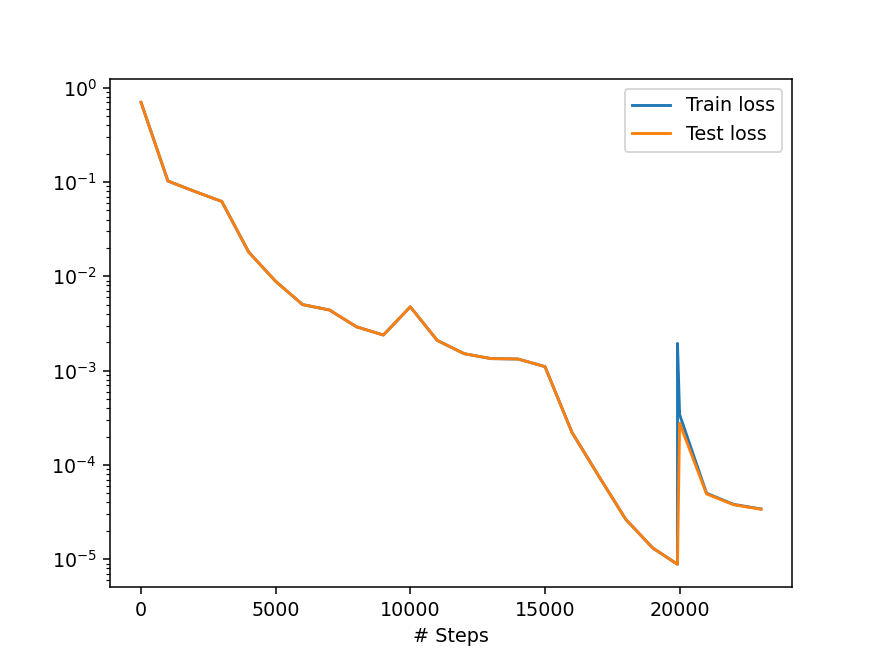

<IPython.core.display.Javascript object>


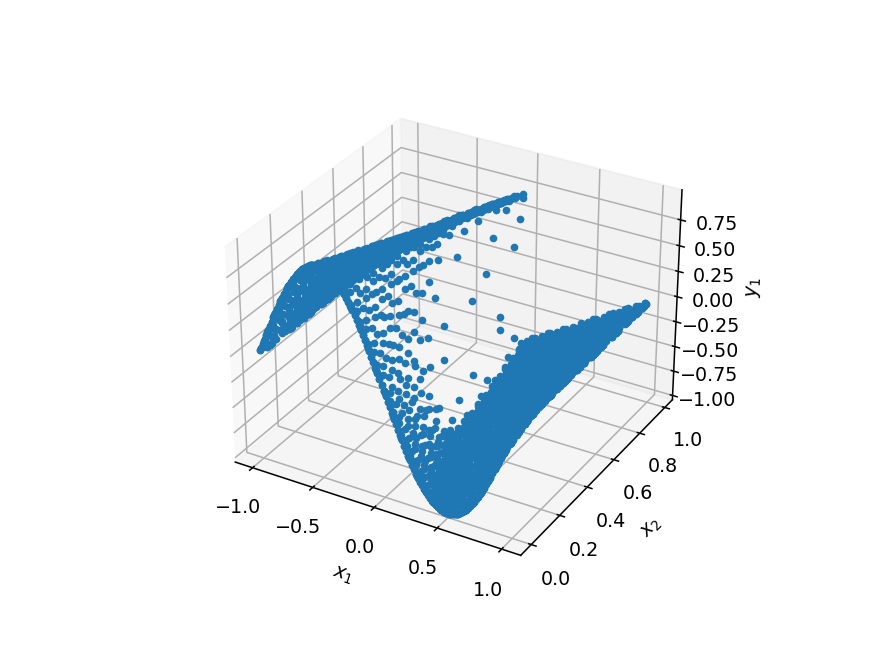

In [29]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname='loss_Burgers_RAR.dat', train_fname='train_Burgers_RAR.dat',test_fname='test_Burgers_RAR.dat')


# Load the Test Data

In [30]:
x_test, y_true, Nx, Nt = gen_testdata()
y_pred = model.predict(x_test)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test_burgers.dat", np.hstack((x_test, y_true, y_pred)))

L2 relative error: 0.029316492801502673


In [31]:
X_test, T_test = x_test[:,0], x_test[:,1]
X = X_test.reshape((Nt, Nx))
T = T_test.reshape((Nt, Nx))
Y_pred = y_pred.reshape((Nt, Nx))
Y_test = y_true.reshape((Nt, Nx))

<IPython.core.display.Javascript object>


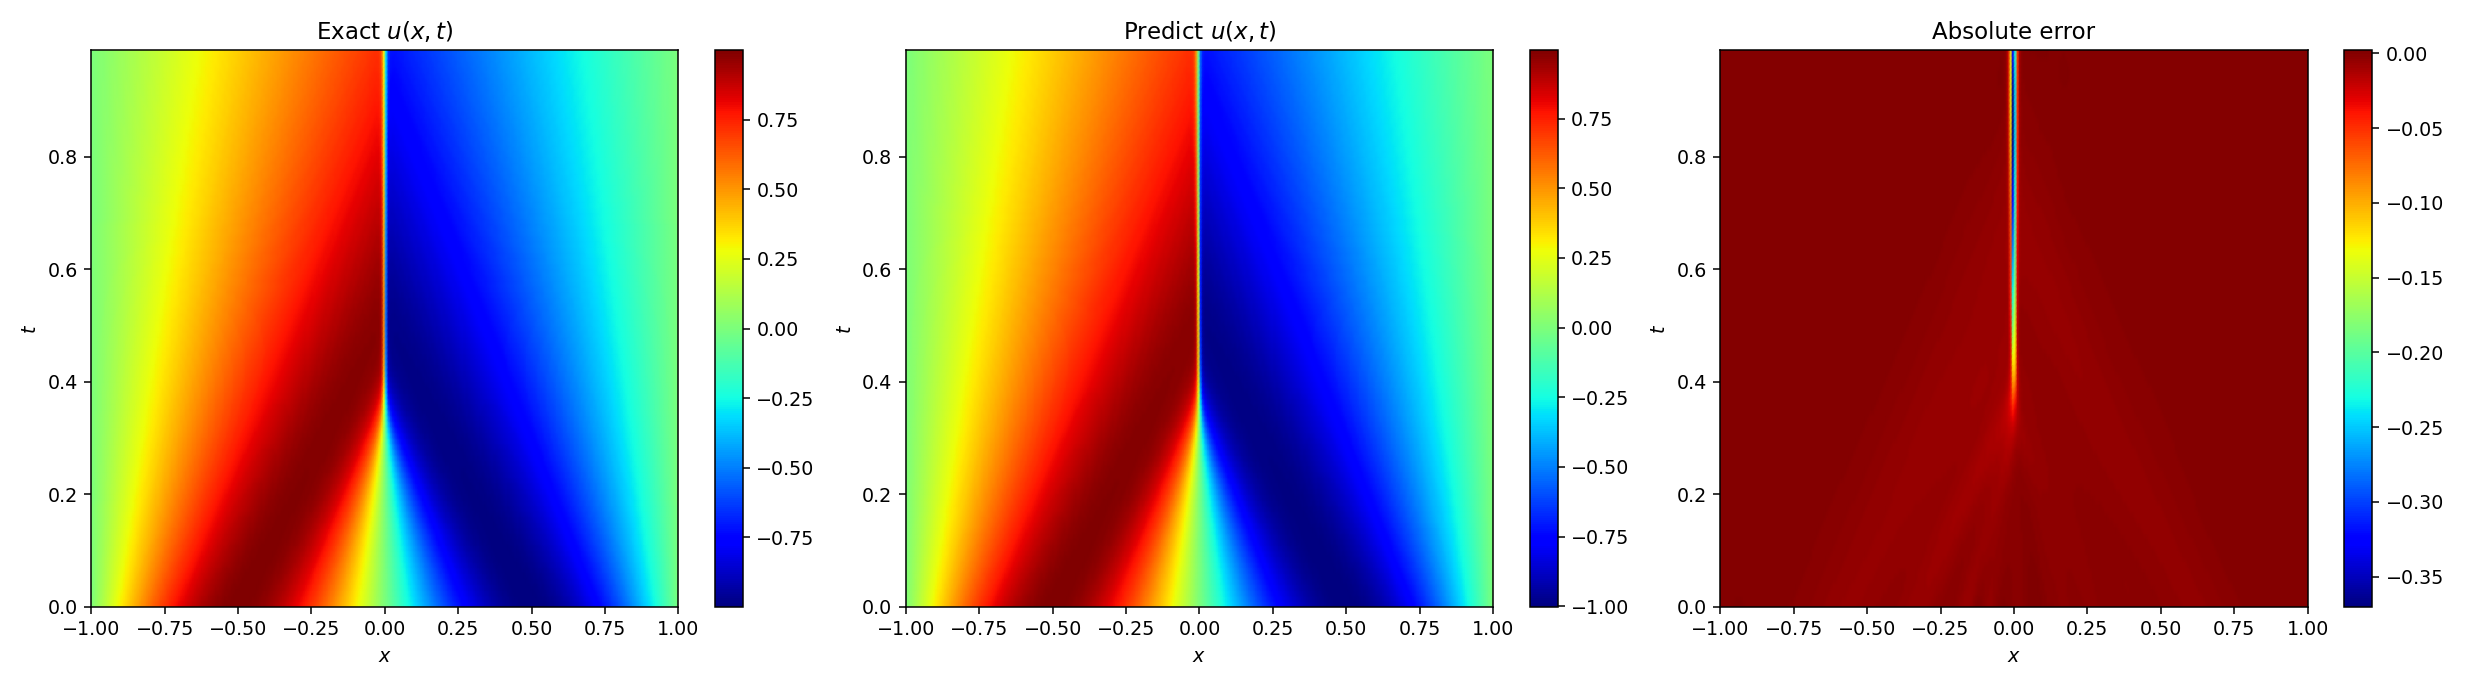

In [32]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, Y_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, Y_pred - Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


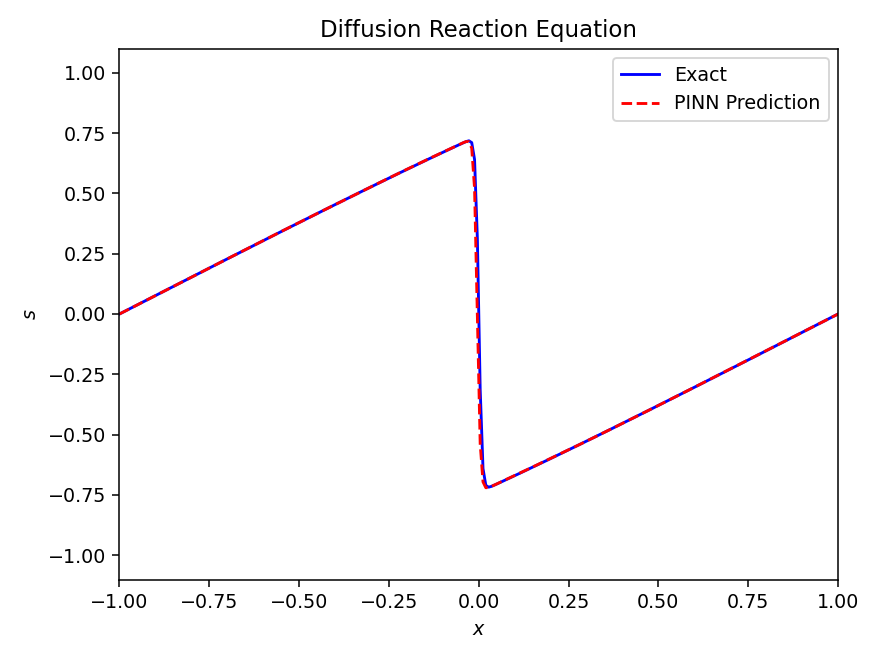

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(X[0], Y_test[0], 'b-', label='Exact')
ax.plot(X[0], Y_pred[0], 'r--', label='PINN Prediction')
ylim = plt.ylim()
xlim = [-1, 1]
plt.tight_layout()


for i in range(Nt):
    ax.clear()
    ax.plot(X[i], Y_test[i], 'b-', label='Exact')
    ax.plot(X[i], Y_pred[i], 'r--', label='PINN Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$s$')
    plt.title(f'Diffusion Reaction Equation')
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.canvas.draw()